In [1]:
import sys
import os

parent = os.path.dirname(os.path.realpath('../../'))
sys.path.append(parent)

import numpy as np
import scipy
import tqdm
import open3d as o3d
import matplotlib.pyplot as plt
import glob

from core import *
from utils import phantom_builder
from utils import geometry

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Make Phantom

In [36]:
voxel_size = np.array([0.001, 0.001, 0.001])
# voxel_size = np.array([0.0005, 0.0005, 0.0005])
surface_mesh = o3d.io.read_triangle_mesh(f"{parent}/assets/cardiac_TEE_phantom/esophageal_surface.ply")
body_mask = phantom_builder.voxelize(voxel_size[0], mesh=surface_mesh) 

In [42]:
test_phantom = phantom.Phantom(source_path = None,
                               voxel_dims = (voxel_size[0], voxel_size[0], voxel_size[0]),
                               matrix_dims = body_mask.shape,
                               baseline = (1540, 1000),
                               seed = None,
                               )

blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=1.3, scale=0.00001, label=1)
myocardium = tissue.Tissue(name='myocardium', c=1592, rho=1081, sigma=20, scale=0.0001, label=2)
esophagus = tissue.Tissue(name='esophagus', c=1500, rho=1100, sigma=10, scale=0.0001, label=3)
fat = tissue.Tissue(name='fat', c=1480, rho=970, sigma=15, scale=0.0001, label=4)

heart_file_dir = f"{parent}/assets/cardiac_TEE_phantom/"
heart_tissue_list = [blood, myocardium, esophagus]

test_phantom.build_organ_from_mesh(surface_mesh, voxel_size[0], heart_tissue_list, dir_path = heart_file_dir)
test_phantom.set_default_tissue(fat)

Added blood
Added myocardium
Added esophagus


In [43]:
test = test_phantom.get_complete()

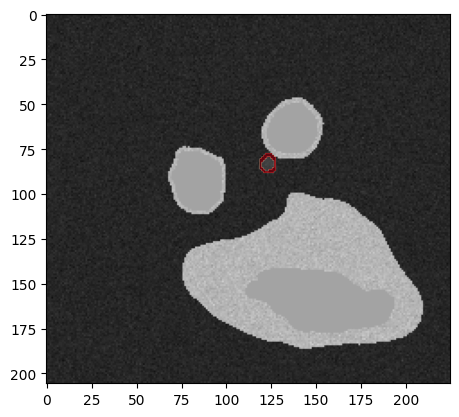

In [44]:
index = 50
plt.imshow(test[0, :, :, index], cmap='gray', vmin=1450, vmax=1650)
plt.imshow(body_mask[:,:, index], alpha=(body_mask[:,:, index]>0)*0.9, cmap='Reds')

# Set up simulation

In [45]:
num_transducers = 6
transducers = [transducer.Focused(max_frequency = 2e6,
                                  elements = 128, 
                                  width = 20e-3,
                                  height =  20e-3,
                                  sensor_sampling_scheme = 'not_centroid', 
                                  sweep = np.pi/2,
                                  ray_num = 128,
                                  imaging_ndims = 2,
                                  focus_azimuth = 100e-3,
                                  focus_elevation = 150e-3,
                                  cycles = 3,
) for i in range(num_transducers)]

for t in transducers:
    t.make_sensor_coords(test_phantom.baseline[0])

test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

In [46]:
test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

# apical 4 chamber
transform1 = geometry.Transform([-np.pi*0.75,0,0], [0,0,0])
transform2 = geometry.Transform([0,-np.pi/2*0.1,0], [0,0,0])
transform3 = geometry.Transform([0,0,0], [0,0,0])
transform = transform1 * transform2 * transform3
position = [-0.15,-0.01,-0.05]
transform.translation = (transform1 * transform2).apply_to_point(position, inverse=False)
test_transducer_set.assign_pose(0, transform)

# apical 2 chamber
transform1 = geometry.Transform([-np.pi*0.75,0,0], [0,0,0])
transform2 = geometry.Transform([0,-np.pi/2*0.1,0], [0,0,0])
transform3 = geometry.Transform([0,0,-np.pi/2], [0,0,0])
transform = transform1 * transform2 * transform3
position = [-0.15,-0.01,-0.05]
transform.translation = (transform1 * transform2).apply_to_point(position, inverse=False)
test_transducer_set.assign_pose(1, transform)

# parasternal shout axis papillary
transform1 = geometry.Transform([-np.pi*0.8,0,0], [0,0,0])
transform2 = geometry.Transform([0,np.pi/2*0.7,0], [0,0,0])
transform3 = geometry.Transform([-np.pi * 0.15,0,-np.pi/2*0.3], [0,0,0])
transform = transform1 * transform2 * transform3
position = np.array([0.095,0.04,0.04])
transform.translation = position
test_transducer_set.assign_pose(2, transform)

# parasternal short axis mitral
transform1 = geometry.Transform([-3.01825409,  0.87793401, -0.87338513], [0,0,0])
transform2 = geometry.Transform([0,0,0], [0,0,0])
transform3 = geometry.Transform([0,0,0], [0,0,0])
transform = transform1 * transform2 * transform3
position = np.array([0.09,0.03,0.056])
transform.translation = position
test_transducer_set.assign_pose(3, transform)

# parasternal long axis
transform1 = geometry.Transform([-3.14,  0.95, -2.51], [0,0,0])
transform2 = geometry.Transform([-0.2,0,0], [0,0,0])
transform3 = geometry.Transform([0,0.04,0], [0,0,0])
transform = transform1 * transform2 * transform3
position = np.array([0.09,0.025,0.045])
transform.translation = position
test_transducer_set.assign_pose(4, transform)

# subcostal 4 chamber
transform1 = geometry.Transform([3,  -0.75, 0], [0,0,0])
transform2 = geometry.Transform([0,0,0], [0,0,0])
transform3 = geometry.Transform([0,0,0], [0,0,0])
transform = transform1 * transform2 * transform3
position = np.array([0.10,0,-0.15])
transform.translation = position
test_transducer_set.assign_pose(5, transform)


# # parasternal short axis aortic
# # suprasternal aortic arch
# print(transform.rotation.as_euler('ZYX', degrees=False))

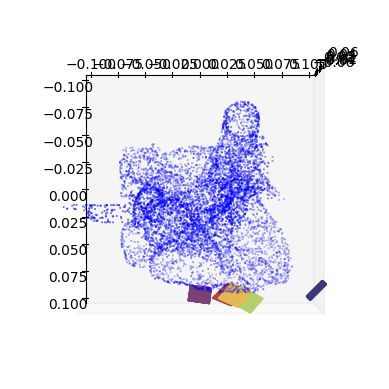

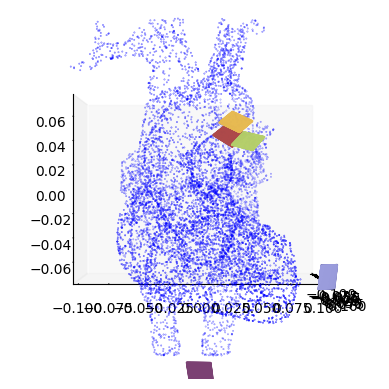

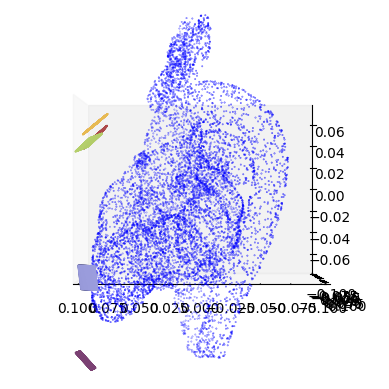

In [47]:
# points = np.array((o3d.io.read_triangle_mesh(f"{parent}/assets/cardiac_TEE_phantom/02_myocardium.obj")).sample_points_uniformly(5000).points)
points = np.array((o3d.io.read_triangle_mesh(f"{parent}/assets/cardiac_TEE_phantom/01_bloodpool.obj")).sample_points_uniformly(8000).points)

test_transducer_set.plot_transducer_coords(scale = 0.1, phantom_coords = points, view=(90,0))
test_transducer_set.plot_transducer_coords(scale = 0.1, phantom_coords = points, view=(0,0))
test_transducer_set.plot_transducer_coords(scale = 0.1, phantom_coords = points, view=(0,90))

In [48]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='transmit_as_receive')

In [49]:
simprops = simulation.SimProperties(
                grid_size   = (200e-3,25e-3,25e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (16,16,16),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [50]:
test_experiment = experiment.Experiment(
                 simulation_path = f'cardiac_TTE_newphantom',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 4,
                 additional_keys = []
                 )

test_experiment.save()

workers is the number of simulations being prepared simultaneously on a single gpu node. Having many workers is RAM intensive and may not decrease overall runtime


In [51]:
sensor_centroids = []
for i in range(len(test_transducer_set)):
    sensor_centroids.append(np.mean(test_sensor.sensor_coords[i*test_sensor.sensor_coords.shape[0]//len(test_transducer_set):(i+1)*test_sensor.sensor_coords.shape[0]//len(test_transducer_set),:], axis=0) / voxel_size + np.array(test.shape[1:])/2)

In [52]:
# test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), int(np.round(sensor_centroids[0][2]))])
# test_experiment.plot_ray_path(0)

In [53]:
# test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), int(np.round(sensor_centroids[0][2]))])
# test_experiment.plot_ray_path(1)

In [54]:
# test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), int(np.round(sensor_centroids[0][2]))])
# test_experiment.plot_ray_path(32)

In [55]:
# test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), int(np.round(sensor_centroids[1][2]))])
# test_experiment.plot_ray_path(64+32)

In [56]:
# test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), int(np.round(sensor_centroids[2][2]))])
# test_experiment.plot_ray_path(128+32)

In [57]:
# test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), int(np.round(sensor_centroids[3][2]))])
# test_experiment.plot_ray_path(196+32)

In [58]:
# test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), int(np.round(sensor_centroids[4][2]))])
# test_experiment.plot_ray_path(256+32)

In [59]:
# test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), int(np.round(sensor_centroids[5][2]))])
# test_experiment.plot_ray_path(320+32)

# Run Simulation

In [2]:
test_experiment = experiment.Experiment.load(f'cardiac_TTE_newphantom')
test_experiment.run(dry=True)

dry run of simulation


100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


In [3]:
test_experiment.run(repeat=False)

Found no more simulations to run.


# Reconstruction

In [4]:
test_experiment.add_results()

In [5]:
test_reconstruction = reconstruction.DAS(experiment=test_experiment)

In [6]:
time,coords,processed = test_reconstruction.preprocess_data(attenuation_factor=10)

100%|██████████| 768/768 [01:09<00:00, 11.12it/s]


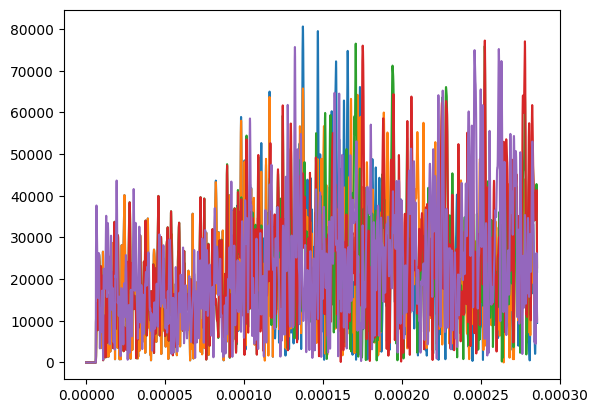

In [7]:
plt.plot(time[0], processed[500])
plt.plot(time[0], processed[501])
plt.plot(time[0], processed[502])
plt.plot(time[0], processed[503])
plt.plot(time[0], processed[504])

In [8]:
# for i,result in tqdm.tqdm(enumerate(test_reconstruction.results)):
#     if result[0].shape[0] != 2477:
#         print(result[0].shape)
#         prit(i)
#         break

In [9]:
signals = test_reconstruction.get_signals(dimensions=2, matsize=512, downsample=1, workers=16, tgc=10)

100%|██████████| 768/768 [02:19<00:00,  5.50it/s]
6it [01:56, 19.48s/it]


[]

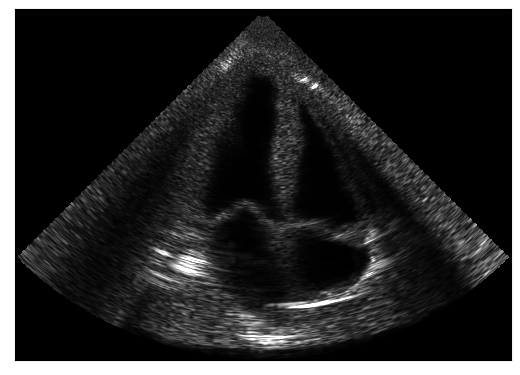

In [10]:
plt.imshow(signals[0], vmin=0, vmax=100000, cmap='gray')
plt.gca().set_facecolor('black')
plt.gca().set_xticks([])
plt.gca().set_yticks([])

[]

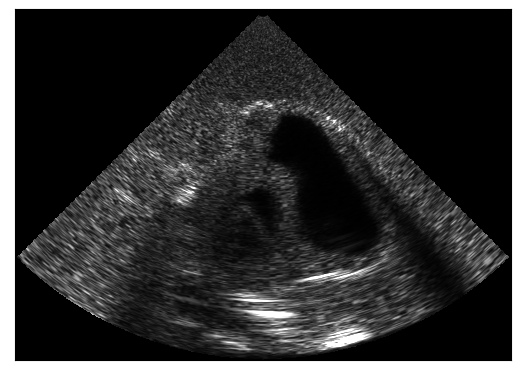

In [11]:
plt.imshow(signals[3], vmin=0, vmax=100000, cmap='gray')
plt.gca().set_facecolor('black')
plt.gca().set_xticks([])
plt.gca().set_yticks([])

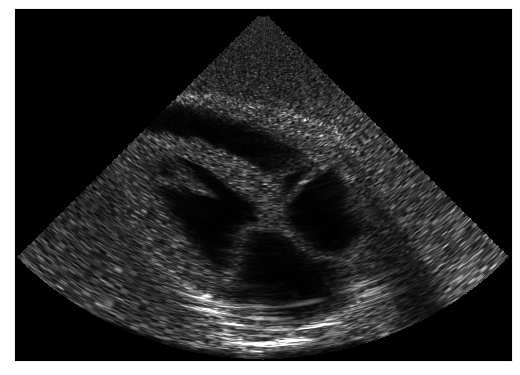

In [12]:
plt.imshow(signals[0], vmin=0, vmax=100000, cmap='gray')
plt.gca().set_facecolor('black')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.savefig('cardiac_TTE_ap4ch_2MHz.png', bbox_inches='tight', pad_inches=0, dpi=300)

plt.imshow(signals[1], vmin=0, vmax=100000, cmap='gray')
plt.gca().set_facecolor('black')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.savefig('cardiac_TTE_ap2ch_2MHz.png', bbox_inches='tight', pad_inches=0, dpi=300)

plt.imshow(signals[3], vmin=0, vmax=100000, cmap='gray')
plt.gca().set_facecolor('black')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.savefig('cardiac_TTE_parasternal_sax_mitral_2MHz.png', bbox_inches='tight', pad_inches=0, dpi=300)

plt.imshow(signals[4], vmin=0, vmax=100000, cmap='gray')
plt.gca().set_facecolor('black')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.savefig('cardiac_TTE_parasternal_lax_2MHz.png', bbox_inches='tight', pad_inches=0, dpi=300)

plt.imshow(signals[5], vmin=0, vmax=100000, cmap='gray')
plt.gca().set_facecolor('black')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.savefig('cardiac_TTE_subcostal_4ch_2MHz.png', bbox_inches='tight', pad_inches=0, dpi=300)

[]

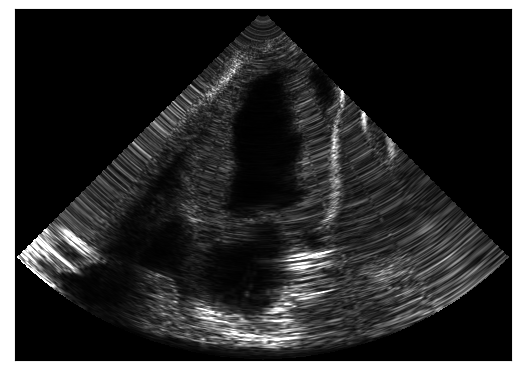

In [80]:
plt.imshow(signals[1], vmin=0, vmax=100000, cmap='gray')
plt.gca().set_facecolor('black')
plt.gca().set_xticks([])
plt.gca().set_yticks([])

[]

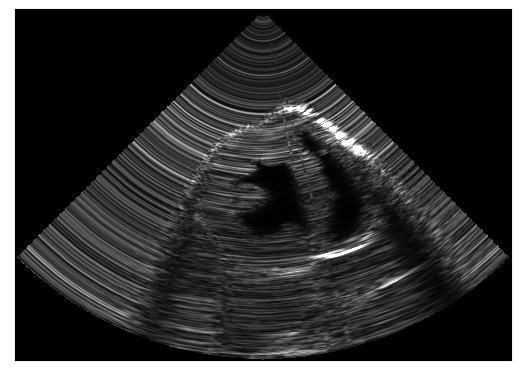

In [81]:
plt.imshow(signals[2], vmin=0, vmax=100000, cmap='gray')
plt.gca().set_facecolor('black')
plt.gca().set_xticks([])
plt.gca().set_yticks([])

[]

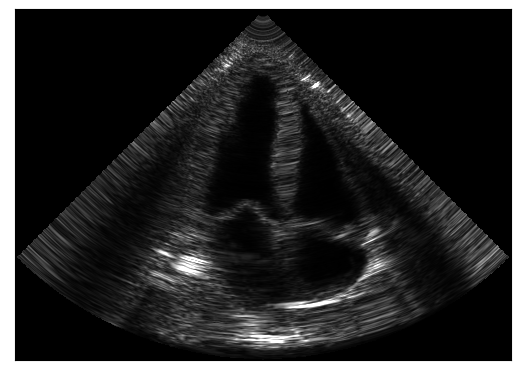

In [62]:
plt.imshow(signals[0], vmin=0, vmax=100000, cmap='gray')
plt.gca().set_facecolor('black')
plt.gca().set_xticks([])
plt.gca().set_yticks([])

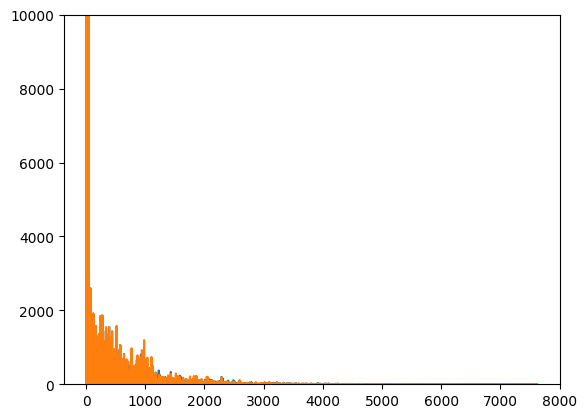

In [79]:
plt.plot(test_reconstruction.results[0][1][0].T)
plt.plot(test_reconstruction.results[4][1][0].T)
plt.ylim(0, 10000)
plt.show()

In [ ]:
from utils import utils

In [ ]:
for i,signal in enumerate(signals):
    # signal = np.where(np.isnan(signal), 0, signal)
    utils.save_mrc(signal, f'output/cardiac_TEE_signals_{i}.mrc')

In [ ]:
image = test_reconstruction.get_image(dimensions=3, matsize=128, downsample=0.5, workers=24, tgc=6)
# image = np.where(np.isnan(image), 0, image)
utils.save_mrc(image, 'output/cardiac_TEE_image.mrc')

/home/trevor/repos/MUSiK/core/utils/geometry.py:216: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  return self.__class__((self.rotation * other.rotation).as_euler("ZYX", degrees=False), self.translation + other.translation)
  7%|▋         | 5978/81920 [00:32<06:56, 182.34it/s]

100%|██████████| 81920/81920 [27:08<00:00, 50.32it/s]  
5it [24:09, 289.90s/it]


In [ ]:
assert False

In [11]:
signals = test_reconstruction.get_signals(dimensions=2, matsize=128, downsample=0.5, workers=16, tgc=10)

  3%|▎         | 2559/81920 [00:04<02:24, 551.08it/s]


KeyboardInterrupt: 

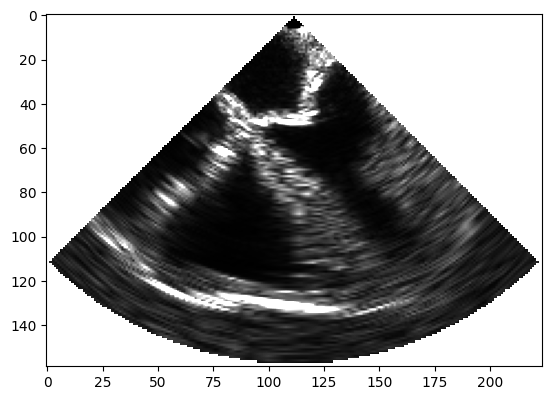

In [6]:
plt.imshow(signals[0], vmax=20000, cmap='gray')

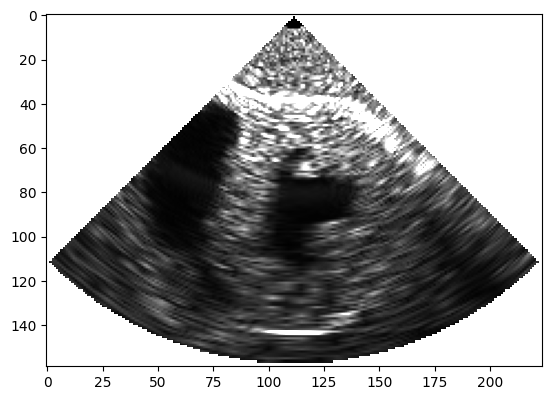

In [9]:
plt.imshow(signals[1], vmax=20000, cmap='gray')

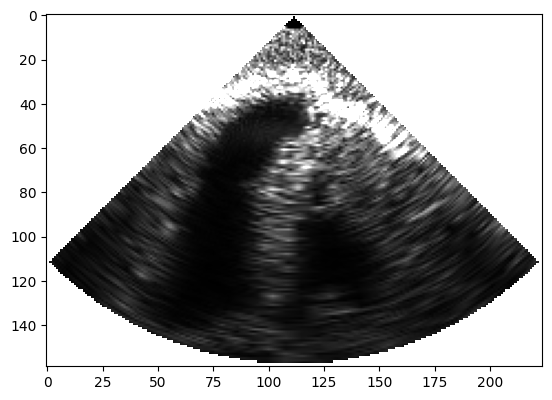

In [10]:
plt.imshow(signals[2], vmax=20000, cmap='gray')

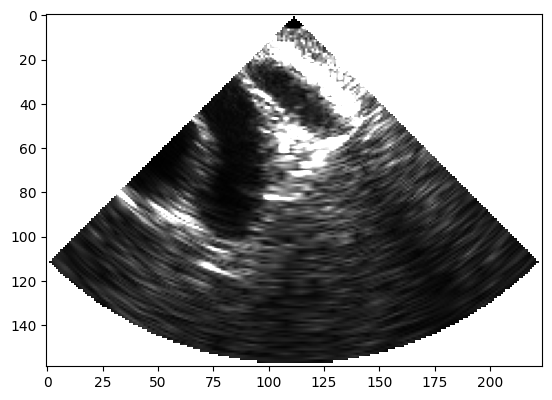

In [11]:
plt.imshow(signals[3], vmax=20000, cmap='gray')

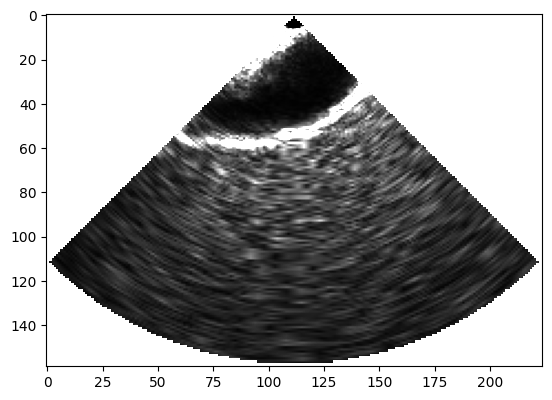

In [12]:
plt.imshow(signals[4], vmax=20000, cmap='gray')